In [3]:
import sys
sys.path.append('..')

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

from flow_matching.path import ProbPath
from flow_matching.path.path_sample import PathSample

import matplotlib.pyplot as plt


In [ ]:
# 1) Define a simple velocity model
class FlowModel(nn.Module):
    def __init__(self, dim=2, hidden=64):  # dim is dimension of datapoint in space, not including time
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden), nn.ELU(),
            nn.Linear(hidden, hidden), nn.ELU(),
            nn.Linear(hidden, dim)
        )
    def forward(self, x, t):
        # x: [B, dim], t: [B] or [B,1]
        if t.ndim == 1:  
            t = t.view(-1, 1)
        t = t.expand(-1, x.shape[-1])
        # concat time as extra feature
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)


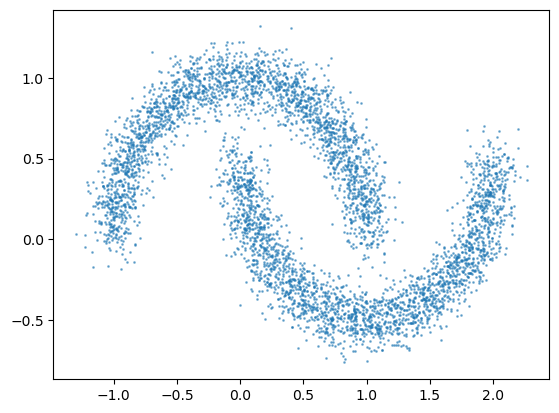

In [20]:
# 2) Prepare toy dataset (make_moons)
X, _ = make_moons(n_samples=5000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
# assume base dist is standard normal in R^2
X0 = torch.randn_like(X)

dataset = TensorDataset(X0, X)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)
plt.scatter(X[:, 0], X[:, 1], s=1, label='X0', alpha=0.5)

In [24]:
# 3) Instantiate path and model
path: ProbPath = ProbPath.Displacement()  
#   - Displacement path uses linear interpolation between x0 and x1
velocity_model = FlowModel(dim=2, hidden=64)
optimizer = optim.Adam(velocity_model.parameters(), lr=1e-3)

AttributeError: type object 'ProbPath' has no attribute 'Displacement'

In [ ]:

# 4) Training loop
for epoch in range(1, 51):
    total_loss = 0.0
    for x_0, x_1 in dataloader:
        batch_size = x_0.size(0)
        # sample random times t ∼ U[0,1]
        t = torch.rand(batch_size, device=x_0.device)
        # draw a PathSample at those t
        sample: PathSample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t = sample.x_t    # [B, 2]
        dx_t = sample.dx_t  # [B, 2], the target velocity
        
        # compute CFM loss = E[‖model(x_t, t) - dx_t‖²]
        pred = velocity_model(x_t, t)
        loss = (pred - dx_t).pow(2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch:02d}  Loss: {avg_loss:.4f}")
